## Digital Inequality Graph Construction

This notebook summarizes the steps we took to construct a graph representing digital inequality across countries, suitable for Graph Neural Network (GNN) training.

---

### 1. Data Preprocessing

- Collected multiple indicators related to digital technology usage and access for countries from 2014 to 2024.
- Pivoted the dataset so that each row represents a country-year combination and columns correspond to indicators.
- Encoded categorical features (`Indicator`, `Economy`, `Indicator_group`) into numerical representations.
- Handled missing values:
  - NaNs were replaced with min value as a signal of low digital development (so that NaN turns into "low development").
  - This ensures that the GNN receives this information as part of the features.


In [18]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import torch
from torch_geometric.data import Data

In [4]:
# Read the file with dataset
df = pd.read_csv("../cleaned_final_dataset.csv")

# Do the pivot: each country+year as a row, indicators as columns
pivot_df = df.pivot_table(
    index=["Economy", "Year"],
    columns="Indicator",
    values="Value"
).reset_index()

# Check it
print(pivot_df.head())

Indicator  Economy  Year  By broadband  By fixed (wired) broadband  \
0          Albania  2019       82.1956                         NaN   
1          Albania  2020       83.2799                         NaN   
2          Albania  2021       88.2611                         NaN   
3          Albania  2022       96.5041                         NaN   
4          Albania  2023       96.7130                         NaN   

Indicator  By fixed broadband and mobile broadband network  \
0                                                  37.4364   
1                                                  49.4303   
2                                                  68.3022   
3                                                  86.3927   
4                                                  86.8086   

Indicator  By fixed broadband network only  By fixed narrowband network  \
0                                 9.112720                          NaN   
1                                 7.757850              

In [5]:
# === 3. Creating binary masks (has_data for each indicator) ===
mask_df = pivot_df.drop(columns=["Economy", "Year"]).notna().astype(int)
mask_df = mask_df.add_prefix("mask_")

# === 4. Index of digital backwardness ===
pivot_df["digital_backwards_index"] = (
    pivot_df.drop(columns=["Economy", "Year"]).isna().sum(axis=1) /
    pivot_df.drop(columns=["Economy", "Year"]).shape[1]
)

In [6]:
# === 5. Imputation with a "fine" ===
# We take the minimum value (or the 5th percentile) so that NaN turns into "low development"
numeric_part = pivot_df.drop(columns=["Economy", "Year", "digital_backwards_index"])
min_values = numeric_part.min(skipna=True)

imputed = numeric_part.apply(lambda col: col.fillna(min_values[col.name]))

In [7]:
# === 6. Normalization ===
scaler = StandardScaler()
X_imputed = scaler.fit_transform(imputed)

# === 7. Collecting the final signs ===
features = np.concatenate([
    X_imputed,                             # normalized values of indicators
    mask_df.values,                        # binary masks
    pivot_df[["digital_backwards_index"]].values  # index of backwardness
], axis=1)

# === 8. Crreate node_id ===
pivot_df["node_id"] = range(len(pivot_df))

In [ ]:
# === 9. Building the edges ===
# (a) Temporary connections
temporal_edges = []
for country in pivot_df["Economy"].unique():
    country_data = pivot_df[pivot_df["Economy"] == country].sort_values("Year")
    ids = country_data["node_id"].tolist()
    for i in range(len(ids) - 1):
        temporal_edges.append((ids[i], ids[i+1]))

# (b) Similar countries in the same year (by digital features)
similarity_edges = []
for year in pivot_df["Year"].unique():
    year_data = pivot_df[pivot_df["Year"] == year]
    X_year = features[year_data.index]
    ids = year_data["node_id"].values

    if len(ids) > 5:  #kNN only makes sense if there are at least 6 countries
        nbrs = NearestNeighbors(n_neighbors=5, metric="cosine").fit(X_year)
        distances, indices = nbrs.kneighbors(X_year)

        for i, node_id in enumerate(ids):
            for j in indices[i][1:]:  # exclude node itself
                similarity_edges.append((node_id, ids[j]))

In [9]:
# === 10. Assembling the graph ===
x = torch.tensor(features, dtype=torch.float)
edges = temporal_edges + similarity_edges
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[734, 123], edge_index=[2, 3571])


Then let's check **the degree** stats and **network features** of the graph:

In [ ]:
# degree info
import numpy as np
edge_arr = edge_index.numpy()
deg = np.bincount(edge_arr.ravel())
print("min:", deg.min(), ", median:", np.median(deg), ", mean:",  deg.mean(), ", max:", deg.max())

# connected components (networkx)
import networkx as nx
G = nx.Graph()
edges = edge_arr.T.tolist()
G.add_edges_from(edges)
print("components:", nx.number_connected_components(G))
sizes = [len(c) for c in nx.connected_components(G)]
print("component sizes (top 10):", sorted(sizes, reverse=True)[:10])

min: 5 , median: 9.0 , mean: 9.730245231607629 , max: 23
components: 1
component sizes (top 10): [734]


**Analysis:** good situation for GNN - there are **no isolates**, the graph is **not too sparse**, but also not excessively dense - which can also be a **problem**. We need to experiment with values of *k* to make sure that final graph structure will be **balanced** and **informative** at the same time to use it with baseline model.

### Graph Construction Analysis

We experimented with different values of *k* in the **k-Nearest Neighbors (kNN)** graph construction process to analyze the structural properties of our dataset. The results are summarized below:


=== k = 5 ===
Nodes: 734, Edges: 6606
Degree stats: min=10, median=18.0, mean=18.00, max=42
Connected components: 7, largest sizes: [684, 24, 6, 5, 5]

=== k = 10 ===
Nodes: 734, Edges: 13946
Degree stats: min=20, median=36.0, mean=38.00, max=84
Connected components: 1, largest sizes: [734]

=== k = 15 ===
Nodes: 734, Edges: 21286
Degree stats: min=30, median=54.0, mean=58.00, max=124
Connected components: 1, largest sizes: [734]


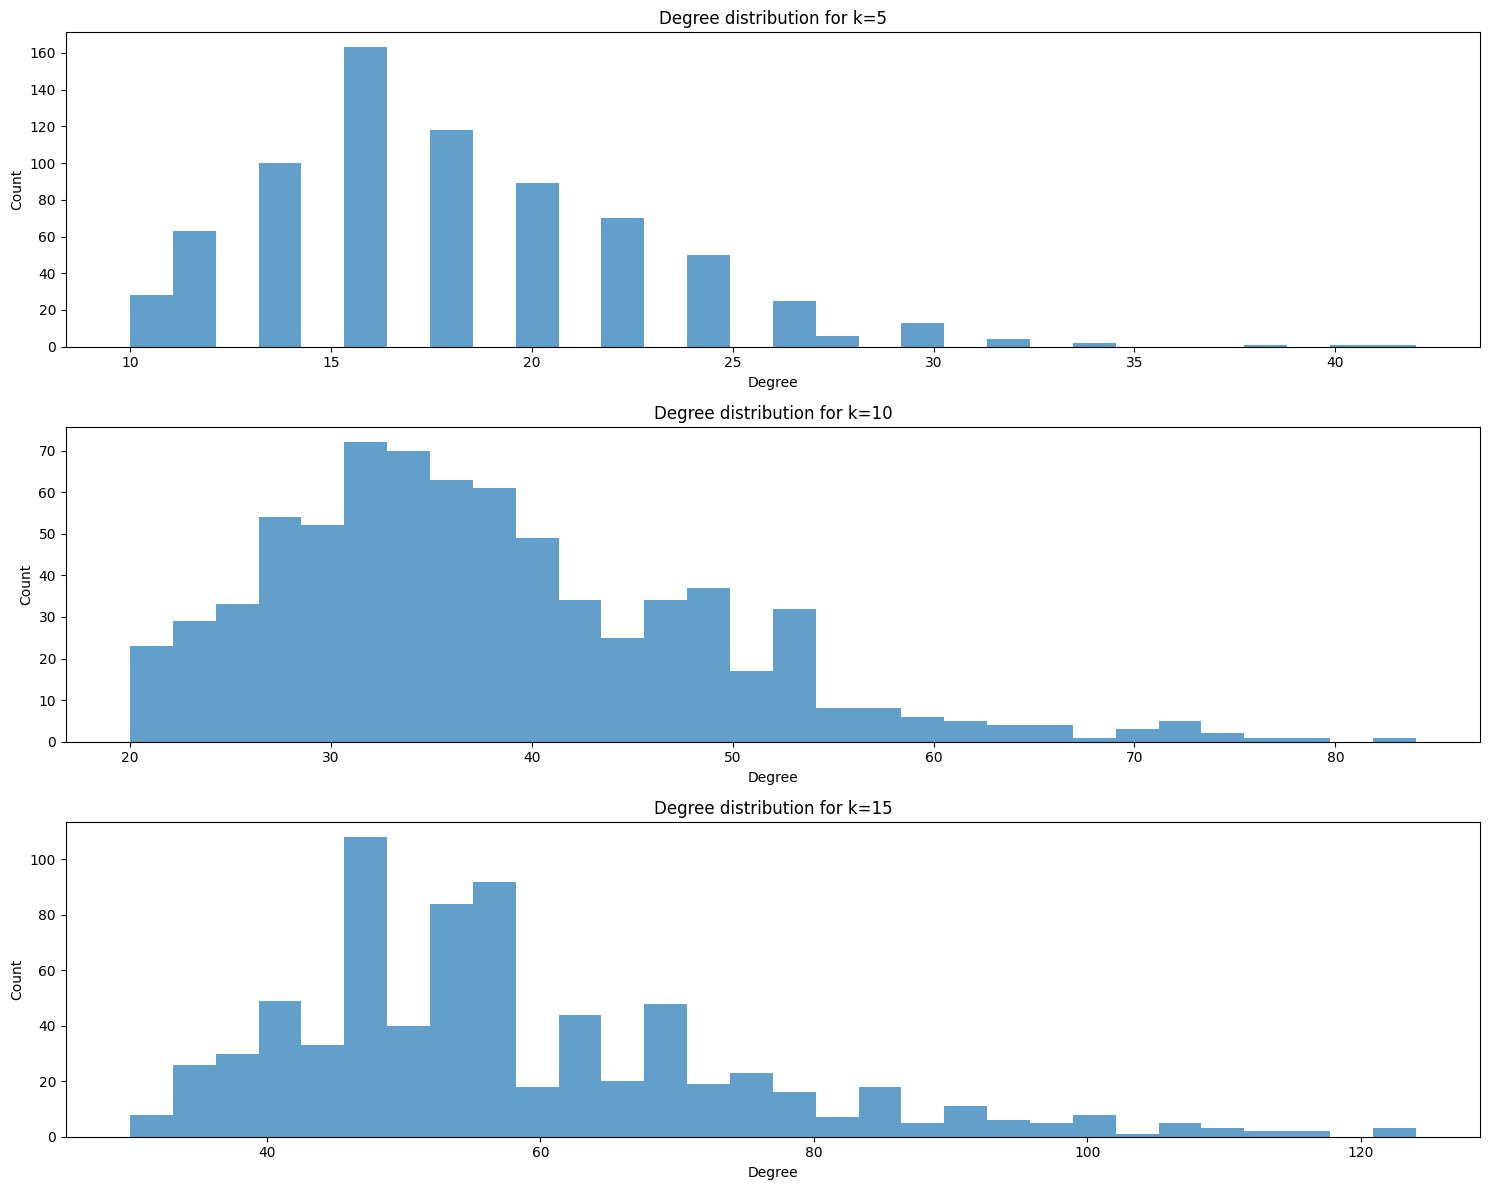

In [15]:
import networkx as nx
from torch_geometric.utils import add_self_loops
import matplotlib.pyplot as plt

def build_graph(X, k):
    """
    X: numpy array (features per node)
    k: number of neighbors
    return: edge_index (torch.tensor), degrees, comp_count, comp_sizes
    """
    nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(X)
    distances, indices = nbrs.kneighbors(X)

    edges = []
    for i in range(len(X)):
        for j in indices[i][1:]:  # exclude self
            edges.append((i, j))

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # make bidirectional
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

    # add self-loops
    edge_index, _ = add_self_loops(edge_index, num_nodes=X.shape[0])

    # degree stats
    edge_arr = edge_index.numpy()
    deg = np.bincount(edge_arr.ravel(), minlength=X.shape[0])

    # connected components
    G = nx.Graph()
    G.add_edges_from(edge_arr.T.tolist())
    comp_count = nx.number_connected_components(G)
    comp_sizes = sorted([len(c) for c in nx.connected_components(G)], reverse=True)

    return edge_index, deg, comp_count, comp_sizes

def analyze_graphs(X, ks=[5,10,15]):
    plt.figure(figsize=(15, 4 * len(ks)))

    for idx, k in enumerate(ks):
        edge_index, deg, comp_count, comp_sizes = build_graph(X, k)
        print(f"\n=== k = {k} ===")
        print(f"Nodes: {X.shape[0]}, Edges: {edge_index.shape[1]}")
        print(f"Degree stats: min={deg.min()}, median={np.median(deg)}, mean={deg.mean():.2f}, max={deg.max()}")
        print(f"Connected components: {comp_count}, largest sizes: {comp_sizes[:5]}")

        # plot histogram
        plt.subplot(len(ks), 1, idx+1)
        plt.hist(deg, bins=30, alpha=0.7)
        plt.title(f"Degree distribution for k={k}")
        plt.xlabel("Degree")
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

# Example call:
analyze_graphs(features, ks=[5,10,15])


### Let's check and analyze the results:

#### k = 5
- **Nodes:** 734  
- **Edges:** 6606  
- **Connected components:** 7 (largest = 684 nodes)  
- **Degree distribution:** sparse and "holey", with many missing values.  
- **Interpretation:** the graph is fragmented into several components. Some countries remain isolated, which prevents efficient information flow across the network.  

#### k = 10
- **Nodes:** 734  
- **Edges:** 13946  
- **Connected components:** 1 (all 734 nodes connected)  
- **Degree distribution:** balanced, most nodes have degrees in the range 30–40.  
- **Interpretation:** this configuration yields a fully connected but not overly dense graph. Information can flow across the entire network while still preserving local structures. This balance is crucial for GNNs, as it allows capturing both global connectivity and regional clusters.

#### k = 15
- **Nodes:** 734  
- **Edges:** 21286  
- **Connected components:** 1 (all 734 nodes connected)  
- **Degree distribution:** uneven, with clear peaks and hubs (some countries with very high degree).  
- **Interpretation:** the graph becomes much denser. Super-hubs dominate the network, which may distort the signal propagation and blur local patterns.

---

### Decision
Based on the analysis, we select **k = 10** as the optimal configuration.  
- It ensures that the graph is **fully connected**.  
- The degree distribution is **balanced**, avoiding both fragmentation (as in k=5) and excessive hub dominance (as in k=15).  
- This structure is best suited for training Graph Neural Networks to capture meaningful patterns in digital inequality data.


---

**Final step:** transform graph to *PyTorch Geometric data* and save to further use with GNN models. 

In [23]:
from torch_geometric.utils import add_self_loops

# our chosen value of k
k = 10

edge_index, deg, comp_count, comp_sizes = build_graph(features, k)

print(f"Graph: {features.shape[0]} nodes, {edge_index.shape[1]} edges")
print(f"Connected components: {comp_count}, largest: {comp_sizes[:5]}")

# graph to PyTorch Geometric Data
edge_index = torch.tensor(edge_index, dtype=torch.long)

# add self-loops
edge_index, _ = add_self_loops(edge_index, num_nodes=features.shape[0])

x = torch.tensor(features, dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

# save to further use with baseline and GNN
torch.save(data, "../digital_inequality_graph.pt")

print(data)


Graph: 734 nodes, 13946 edges
Connected components: 1, largest: [734]
Data(x=[734, 123], edge_index=[2, 14680])


C:\Users\aldir\AppData\Local\Temp\ipykernel_25372\4234033144.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype=torch.long)
